In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from os import *

from tensorflow.keras import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *

from tensorflow_hub import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# device setups
environ["TFHUB_CACHE_DIR"] = r'.\cache'
environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = "false"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
ds_dir = 'G:\!Works\BenchData'

In [4]:
module_selection = ("mobilenet_v3_small_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/5".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))


Using https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5 with input size (224, 224)


In [10]:
BATCH_SIZE = 2048
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="nearest")
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                horizontal_flip=True,
                                                                width_shift_range=0.2, height_shift_range=0.2,
                                                                shear_range=0.2, zoom_range=0.2,
                                                                **datagen_kwargs)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

In [11]:
train_generator = train_datagen.flow_from_directory(ds_dir, subset="training", shuffle=True, **dataflow_kwargs)
valid_generator = valid_datagen.flow_from_directory(ds_dir, subset="validation", shuffle=False, **dataflow_kwargs)

Found 2880 images belonging to 9 classes.
Found 720 images belonging to 9 classes.


In [12]:
do_fine_tuning = False
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
        hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        BatchNormalization(),
        tf.keras.layers.Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    ])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1024)              1529968   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
______________________

In [13]:
metric = 'val_accuracy'
callbacks = [TensorBoard(log_dir=".logs/", histogram_freq=1),
             #ModelCheckpoint(filepath=".checkpoints/", monitor=metric, verbose=2, save_best_only=True, mode='max'),
             #EarlyStopping(monitor=metric, patience=5)
            ]

In [14]:
starttime = time.time()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1), metrics=['accuracy'])
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(train_generator, epochs=20, steps_per_epoch=steps_per_epoch,
                 validation_data=valid_generator, validation_steps=validation_steps,
                 callbacks=callbacks).history
endtime = time.time()
elapsedtime = endtime - starttime
print("Elapsed time: %1.3f s" % elapsedtime)

Epoch 1/20
1/1 [==============================] - 24s 24s/step - loss: 2.7979 - accuracy: 0.1262
Epoch 2/20
1/1 [==============================] - 25s 25s/step - loss: 2.8283 - accuracy: 0.1245
Epoch 3/20
1/1 [==============================] - 24s 24s/step - loss: 2.7339 - accuracy: 0.1431
Epoch 4/20
1/1 [==============================] - 10s 10s/step - loss: 2.6069 - accuracy: 0.1743
Epoch 5/20
1/1 [==============================] - 23s 23s/step - loss: 2.4875 - accuracy: 0.1982
Epoch 6/20
1/1 [==============================] - 24s 24s/step - loss: 2.3074 - accuracy: 0.2476
Epoch 7/20
1/1 [==============================] - 26s 26s/step - loss: 2.1263 - accuracy: 0.3179
Epoch 8/20
1/1 [==============================] - 11s 11s/step - loss: 1.9851 - accuracy: 0.3498
Epoch 9/20
1/1 [==============================] - 10s 10s/step - loss: 1.8123 - accuracy: 0.4303
Epoch 10/20
1/1 [==============================] - 25s 25s/step - loss: 1.7520 - accuracy: 0.4653
Epoch 11/20
1/1 [============

KeyError: 'val_loss'

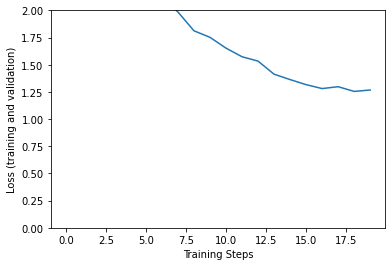

In [15]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        80
           1       0.81      0.28      0.41        80
           2       0.75      0.85      0.80        80
           3       0.72      0.99      0.83        80
           4       0.89      0.90      0.89        80
           5       0.00      0.00      0.00        80
           6       0.29      0.68      0.40        80
           7       0.51      0.51      0.51        80
           8       0.88      0.72      0.79        80

    accuracy                           0.65       720
   macro avg       0.65      0.65      0.62       720
weighted avg       0.65      0.65      0.62       720



Text(159.0, 0.5, 'True')

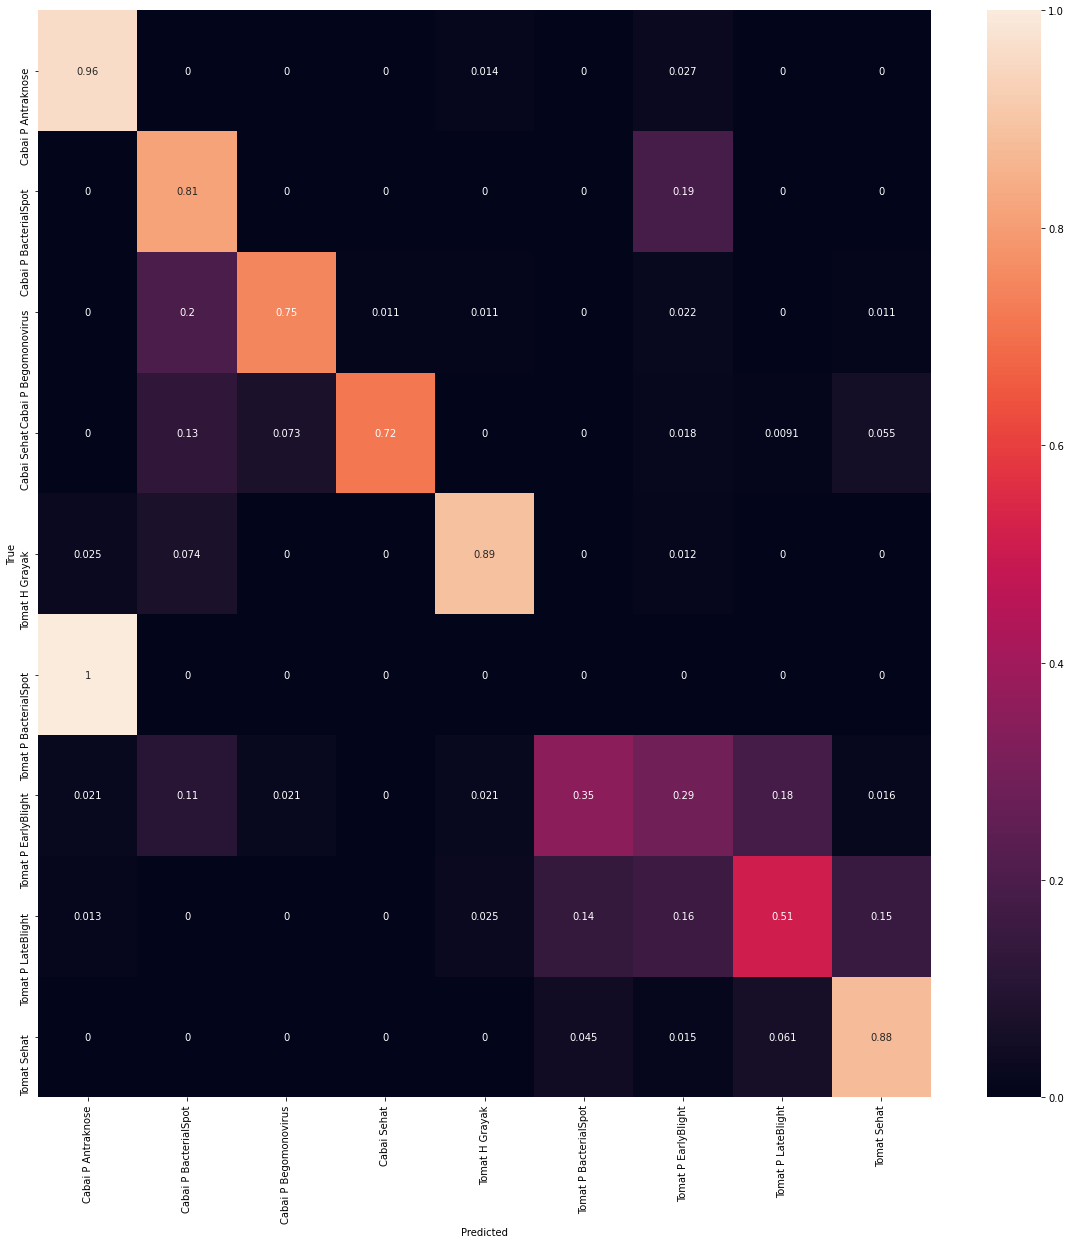

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

true_categories = valid_generator.classes
y_pred = model.predict(valid_generator)
predicted_categories = tf.argmax(y_pred, axis=1)

cm = tf.math.confusion_matrix(predicted_categories, true_categories)

report = classification_report(true_categories, predicted_categories)
print(report)
# cm = tf.math.confusion_matrix(validation_df['Sentiment'], predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20, 20))
sns.heatmap(
    cm, annot=True,
    xticklabels=valid_generator.class_indices.keys(),
    yticklabels=valid_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")

# print(train_generator.class_indices.keys())